In [31]:
import os
import re
import cv2
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from TrainDataset import TrainDataset
from TestDataset import TestDataset
#from model import ReconNet
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
%matplotlib inline

In [45]:
path = './images/all_images/BSDS200'
compression_percentage = 25
compression_rate = compression_percentage/100
name='new_Final_Model_lastest_200_epoch_25_compression_rate'
original_image = './images/test_sample_' + name + '.png'
sample_image = './images/sample_result_' + name + '.png'
model_name = 'model_state_'+ name +'.pth'
test_file_name = 'test1.png'
ratio_dict = {1: 10, 4: 43, 10: 109, 25: 272, 30: 327, 40: 436, 50: 545}

In [48]:
ratio_dict[compression_percentage]

272

In [33]:
import cv2
import matplotlib.pyplot as plt

def resize_image(image, target_height=237, target_width=374):
    """
    Resize an image to the specified dimensions while handling padding for shrinking or zooming.
    
    Args:
    - image: Input image as a numpy array.
    - target_height: Target height for resizing.
    - target_width: Target width for resizing.
    
    Returns:
    - Resized image as a numpy array with dimensions (target_height, target_width, 3).
    """
    # Get the original dimensions of the image
    original_height, original_width, _ = image.shape
    
    # Calculate scaling factors for resizing
    scale_height = target_height / original_height
    scale_width = target_width / original_width
    
    # Decide whether to shrink or zoom the image based on scaling factors
    if scale_height < 1 or scale_width < 1:
        # Shrink the image by adding padding
        new_height = min(target_height, original_height)
        new_width = min(target_width, original_width)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        
        # Add padding to match the target dimensions
        top_padding = (target_height - new_height) // 2
        bottom_padding = target_height - new_height - top_padding
        left_padding = (target_width - new_width) // 2
        right_padding = target_width - new_width - left_padding
        resized_image = cv2.copyMakeBorder(resized_image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=(0, 0, 0))
    else:
        # Zoom the image by adding padding
        new_height = max(target_height, original_height)
        new_width = max(target_width, original_width)
        resized_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        
        # Crop the image to match the target dimensions
        start_x = (new_width - target_width) // 2
        start_y = (new_height - target_height) // 2
        resized_image = resized_image[start_y:start_y + target_height, start_x:start_x + target_width]
    
    return resized_image

# Example usage:
# Load an image using OpenCV
# img = cv2.imread("image.jpg")
# Resize the image
# resized_img = resize_image(img, target_height=237, target_width=374)


In [34]:
import cv2

def restore_image(image, original_height, original_width):
    """
    Restore an image to its original dimensions from a resized image.
    
    Args:
    - image: Resized image as a numpy array.
    - original_height: Original height of the image.
    - original_width: Original width of the image.
    
    Returns:
    - Restored image as a numpy array with dimensions (original_height, original_width, 3).
    """
    # Get the dimensions of the resized image
    resized_height, resized_width, _ = image.shape
    
    # Calculate the scaling factors for zooming or shrinking
    scale_height = original_height / resized_height
    scale_width = original_width / resized_width
    
    # Decide whether to zoom or shrink the image based on scaling factors
    if scale_height < 1 or scale_width < 1:
        # Zoom the image by merging pixels
        restored_image = cv2.resize(image, (original_width, original_height), interpolation=cv2.INTER_CUBIC)
    else:
        # Shrink the image by adding new pixels
        restored_image = cv2.resize(image, (original_width, original_height), interpolation=cv2.INTER_AREA)
    
    return restored_image

# Example usage:
# original_height, original_width = 1707, 2560
# restored_img = restore_image(resized_img, original_height, original_width)


In [37]:
def normalize(v):
    return v / np.sqrt(v.dot(v))

def generate_phi(x, y):
    np.random.seed(333)
    phi = np.random.normal(size=(x, y))
    n = len(phi)
    
    # perform Gramm-Schmidt orthonormalization
    
    phi[0, :] = normalize(phi[0, :])
    
    for i in range(1, n):
        Ai = phi[i, :]
        for j in range(0, i):
            Aj = phi[j, :]
            t = Ai.dot(Aj)
            Ai = Ai - t * Aj
        phi[i, :] = normalize(Ai)
        
    return phi

mat = generate_phi(ratio_dict[compression_percentage], 1089)
mat = torch.from_numpy(mat)
print(mat.shape)

torch.Size([272, 1089])


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import ceil

class Model(nn.Module):
    def __init__(self, measurement_rate=0.25):
        super(Model, self).__init__()

        self.measurement_rate = measurement_rate

        # Fully connected layers
        self.fc1 = nn.Linear(ratio_dict[compression_percentage], 1089)
        nn.init.xavier_normal_(self.fc1.weight)

        # Dropout layer
        self.dropout = nn.Dropout(p=0.2)

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 7, 1, padding=3)
        nn.init.xavier_normal_(self.conv1.weight)

        self.conv2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        nn.init.xavier_normal_(self.conv2.weight)

        self.conv3 = nn.Conv2d(32, 16, 3, 1, padding=1)
        nn.init.xavier_normal_(self.conv3.weight)

        self.conv4 = nn.Conv2d(16, 16, 3, 1, padding=1)
        nn.init.xavier_normal_(self.conv4.weight)

        self.conv5 = nn.Conv2d(16, 8, 3, 1, padding=1)
        nn.init.xavier_normal_(self.conv5.weight)

        self.conv6 = nn.Conv2d(8, 1, 3, 1, padding=1)
        nn.init.xavier_normal_(self.conv6.weight)

    def forward(self, x):
        # Sparse representation learning
        x = x.view(-1, int(self.measurement_rate * 1089))  # Flatten input
        x = F.relu(self.fc1(x))

        x = x.view(-1, 33, 33)  # Reshape output to match the expected shape
        
        # Adding channel dimension
        x = x.unsqueeze(1)
        
        # Convolutional layers for feature extraction
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        
        # Reconstruction layer
        x = self.conv6(x)

        return x


In [25]:
import torch
import time
import numpy as np

transformations = transforms.Compose([transforms.ToTensor()])
train_data = TrainDataset(path,mat,transformations,compression_rate)

train_dl = DataLoader(train_data,batch_size=128)

train_iter = iter(train_dl)
images , labels = next(train_iter)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

model = Model(measurement_rate=compression_rate)
model = nn.DataParallel(model)
model = model.cuda()
print(model)


optimizer = optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

criterion = nn.MSELoss()
criterion = criterion.cuda()


DataParallel(
  (module): Model(
    (fc1): Linear(in_features=272, out_features=1089, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)


In [8]:
import torch
import time
import numpy as np
import os
from skimage.metrics import peak_signal_noise_ratio as psnr

# Create a directory to save models
os.makedirs('saved_models', exist_ok=True)

total_start_time = time.time()

def train(model, criterion, optimizer, train_dl, num_epochs=10, scheduler=None, early_stopping_patience=10):
    best_train_loss = float('inf')
    patience_counter = 0

    # Move model to CUDA device once
    model = model.cuda()

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = []
        psnr_values = []
        model.train()

        for inp, lbl in train_dl:
            inp = inp.cuda().float()
            lbl = lbl.cuda().float()

            optimizer.zero_grad()
            out = model(inp)
            out = out.view(lbl.size())
            loss = criterion(out, lbl)
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            # Calculate PSNR
            out_cpu = out.detach().cpu().numpy()
            lbl_cpu = lbl.detach().cpu().numpy()
            psnr_values.append(psnr(lbl_cpu, out_cpu))

        epoch_time = time.time() - start_time
        total_time = time.time() - total_start_time  # Total time taken for all epochs so far

        mean_train_loss = np.mean(train_loss)
        mean_psnr = np.mean(psnr_values)

        print(f'Epoch: {epoch+1}/{num_epochs}, Training Loss: {mean_train_loss:.6f}, PSNR: {mean_psnr:.2f}, Time taken: {epoch_time:.2f} seconds, Total time taken: {total_time:.2f} seconds')

        # Save the best model
        if mean_train_loss < best_train_loss:
            best_train_loss = mean_train_loss
            patience_counter = 0
            model_path = os.path.join('saved_models', f'best_model_epoch_{epoch+1}.pth')
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model at epoch {epoch+1} with training loss: {mean_train_loss:.6f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

        # Learning rate scheduler
        if scheduler:
            scheduler.step()

    total_duration = time.time() - total_start_time
    print(f"Training completed in: {total_duration:.2f} seconds")


In [ ]:
# Pass the scheduler to train function
train(model, criterion, optimizer, train_dl, num_epochs=10)


In [ ]:
torch.save(model.state_dict(), model_name)

In [26]:
state_dict = torch.load(model_name,map_location ='cpu')
model.load_state_dict(state_dict)
model.eval()

DataParallel(
  (module): Model(
    (fc1): Linear(in_features=272, out_features=1089, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

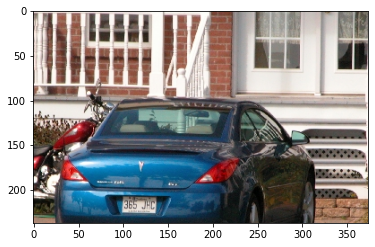

In [27]:
test_img = plt.imread('./images/' + test_file_name)
plt.imshow(test_img)

Test Loss: 0.004934997763484716
Test PSNR: 23.06713035620968


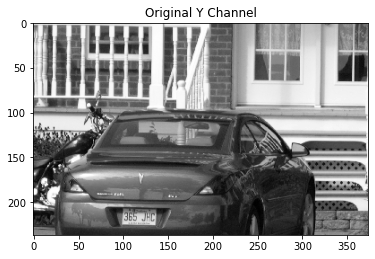

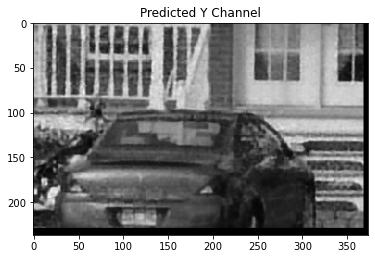

Test Loss: 3.34715805365704e-05
Test PSNR: 44.75323786630305


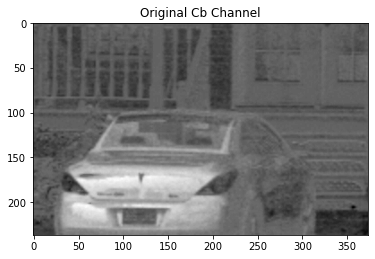

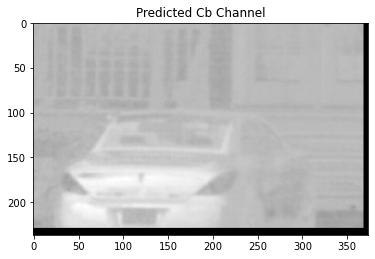

Test Loss: 9.00333106983453e-05
Test PSNR: 40.455967811384035


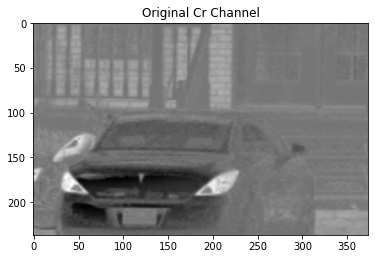

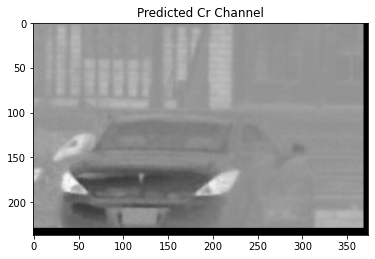

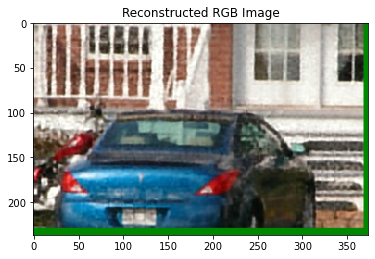

In [39]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Define your model, dataset, transformations, and other necessary components here

# Load the image
test_img = plt.imread('./images/' + test_file_name)
x_dim, y_dim, _ = test_img.shape
test_img = resize_image(test_img, target_height=237, target_width=374)

# Convert to YCbCr color space
test_img_ycbcr = cv2.cvtColor(test_img, cv2.COLOR_BGR2YCR_CB)

# Normalize the image
test_img_ycbcr = cv2.normalize(test_img_ycbcr, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Separate the channels
y_channel = test_img_ycbcr[:,:,0]
cb_channel = test_img_ycbcr[:,:,1]
cr_channel = test_img_ycbcr[:,:,2]

reconstructed_img_ycbcr = np.zeros(test_img.shape)
reconstructed_y_channel = []
reconstructed_cb_channel = []
reconstructed_cr_channel = []

# Process each channel
for channel_name, channel, index in [('Y', y_channel,0), ('Cb', cb_channel,1), ('Cr', cr_channel,2)]:
    h, w = channel.shape
    stride = 14
    filter_size = 33
    h_n = ((h - filter_size) // stride) + 1
    w_n = ((w - filter_size) // stride) + 1
    
    image_blocks = []
    
    for i in range(h_n):
        for j in range(w_n):
            blocks = channel[i*stride:(i*stride)+filter_size, j*stride:(j*stride)+filter_size]
            image_blocks.append(blocks)

    image_blocks = np.array(image_blocks)

    # Assuming you have defined TestDataset and DataLoader for your dataset
    test_data = TestDataset(image_blocks, mat, transformations, compression_rate)
    test_dl = DataLoader(test_data, batch_size=1089)

    # Load the model
    model.load_state_dict(torch.load(model_name, map_location='cpu'))

    # Model Output
    inp, lbl = next(iter(test_dl))
    inp = inp.cuda().float()
    lbl = lbl.cuda().float()

    out = model(inp)
    out = out.view(lbl.size())
    loss = criterion(out, lbl)
    print('Test Loss:', loss.item())

    # Calculate PSNR
    out_cpu = out.detach().cpu().numpy()
    lbl_cpu = lbl.detach().cpu().numpy()
    psnr_value = psnr(lbl_cpu, out_cpu)
    print('Test PSNR:', psnr_value)


    # Reconstruct the image
    out = out.view(-1, 33, 33).cpu().detach().numpy()
    reconstructed_channel = np.zeros((h, w))

    k = 0
    for i in range(h_n):
        for j in range(w_n):
            reconstructed_channel[i*stride:(i*stride)+filter_size, j*stride:(j*stride)+filter_size] = out[k]
            k += 1

    # Merge the processed channel
    if channel is y_channel:
        reconstructed_img_ycbcr = np.stack((reconstructed_channel, reconstructed_img_ycbcr[:,:,1], reconstructed_img_ycbcr[:,:,2]), axis=-1)
        reconstructed_y_channel = reconstructed_channel
    elif channel is cb_channel:
        reconstructed_img_ycbcr = np.stack((reconstructed_img_ycbcr[:,:,0], reconstructed_channel, reconstructed_img_ycbcr[:,:,2]), axis=-1)
        reconstructed_cb_channel = reconstructed_channel
    else:
        reconstructed_img_ycbcr = np.stack((reconstructed_img_ycbcr[:,:,0], reconstructed_img_ycbcr[:,:,1], reconstructed_channel), axis=-1)
        reconstructed_cr_channel = reconstructed_channel
        
    #print('PSNR : ', peak_signal_noise_ratio(test_img[:,:,index], reconstructed_channel))
    # Display or save the individual channel image
    plt.imshow(channel, cmap='gray')
    plt.title('Original ' + channel_name + ' Channel')
    plt.savefig('./images/sample_result_' + name + '_' + channel_name + '_original.png', bbox_inches='tight')
    plt.show()

    # Display or save the predicted channel image
    plt.imshow(reconstructed_channel, cmap='gray')
    plt.title('Predicted ' + channel_name + ' Channel')
    plt.savefig('./images/sample_result_' + name + '_' + channel_name + '_predicted.png', bbox_inches='tight')
    plt.show()

#print('PSNR : ', peak_signal_noise_ratio(test_img[:,:,0].astype(np.float64), reconstructed_img_ycbcr[:,:,0]))

# Convert back to RGB
reconstructed_img_ycbcr_uint8 = np.clip(reconstructed_img_ycbcr * 255, 0, 255).astype(np.uint8)
reconstructed_img_rgb = cv2.cvtColor(reconstructed_img_ycbcr_uint8, cv2.COLOR_YCR_CB2BGR)

# Display or save the reconstructed RGB image
plt.imshow(reconstructed_img_rgb)
plt.title('Reconstructed RGB Image')
plt.savefig('./images/sample_result_' + name + '_RGB.png', bbox_inches='tight')
plt.show()


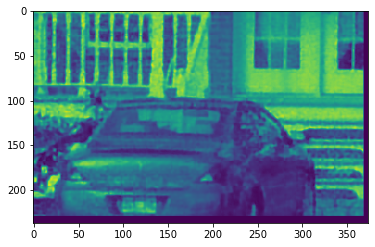

In [40]:
plt.imshow(reconstructed_y_channel)

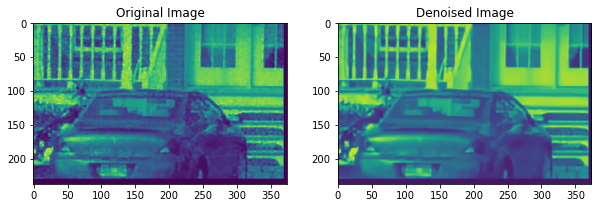

PSNR :  14.61776015210515


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from bm3d import bm3d

def apply_bm3d_denoiser(rgb_image, sigma):
    """
    Apply BM3D denoiser to an RGB image using the bm3d library.
    
    Args:
    - rgb_image: Input RGB image (numpy array).
    - sigma: Standard deviation of the noise in the image.
    
    Returns:
    - Denoised RGB image (numpy array).
    """
    # Apply BM3D denoiser to the RGB image
    denoised_image = bm3d(rgb_image, sigma)
    
    return denoised_image

# Example usage:
# Load the RGB image
rgb_image = reconstructed_y_channel

# Set the standard deviation of the noise (adjust as needed)
sigma = 0.1

# Apply BM3D denoiser
denoised_image = apply_bm3d_denoiser(rgb_image, sigma)

# Display the original and denoised images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(rgb_image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image)
plt.title('Denoised Image')

plt.show()

# Calculate PSNR for the entire image
psnr_value = peak_signal_noise_ratio(test_img[:,:,0].astype(np.float64), reconstructed_y_channel)
print('PSNR : ', psnr_value)

Text(0.5, 1.0, 'Reconstructed RGB Image')

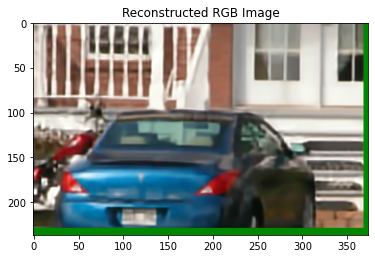

In [42]:
reconstructed_img = np.stack((denoised_image, reconstructed_cb_channel, reconstructed_cr_channel), axis=-1)
# Convert back to RGB
reconstructed_img_uint8 = np.clip(reconstructed_img * 255, 0, 255).astype(np.uint8)
reconstructed_denoised_img_rgb = cv2.cvtColor(reconstructed_img_uint8, cv2.COLOR_YCR_CB2BGR)

# Display or save the reconstructed RGB image
plt.imshow(reconstructed_denoised_img_rgb)
plt.title('Reconstructed RGB Image')

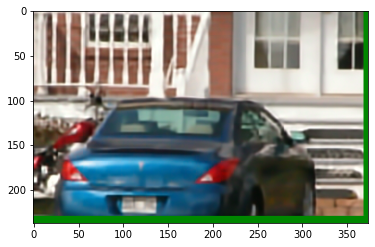

In [43]:
reconstructed_denoised_img_rgb_resized = restore_image(reconstructed_denoised_img_rgb, x_dim, y_dim)
plt.imshow(reconstructed_denoised_img_rgb_resized)

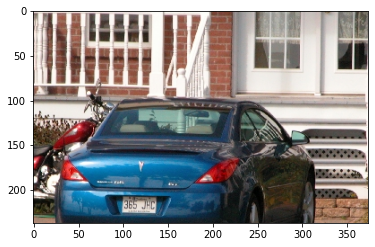

In [44]:
plt.imshow(test_img)